In [1]:
# Clone the detr github repo
!git clone https://github.com/facebookresearch/detr.git
import os
os.chdir('detr')
!git checkout 8a144f83a287f4d3fece4acdf073f387c5af387d

fatal: destination path 'detr' already exists and is not an empty directory.


M	datasets/coco.py
M	engine.py
HEAD is now at 8a144f8 docs: add GH button in support of Ukraine (#490)


In [2]:
# Import required libraries
import argparse
import random
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import PIL.Image

import util.misc as utils
from models import build_model

from main import get_args_parser

In [3]:
import torch

model = torch.load('/Users/jiaruili/Emotion Recognition/Code/detr_model_full.pth')
model.eval()

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [4]:
# COCO Classes
CLASSES = [
   'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
   'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
   'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
   'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
   'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
   'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
   'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
   'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
   'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
   'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
   'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
   'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
   'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
   'toothbrush'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# Resize bounding boxes to be full size of the image
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
def detect(im, model, transform):
  img = transform(im).unsqueeze(0)
  assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'Demo model only supports images up to 1600 on each side.'
  outputs = model(img)
  probas = outputs['pred_logits'].softmax(-1)[0,:,:-1]
  keep = probas.max(-1).values > 0.7
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0,keep], im.size)
  return probas[keep], bboxes_scaled

def plot_results(pil_img, class_probs, b_boxes, classes, is_ground_truth=False):
    plt.figure(figsize=(16,10))
    plt.axis('off')
    ax = plt.gca()
    ax.imshow(pil_img)

    for p, (xmin, ymin, xmax, ymax), c in zip(class_probs, b_boxes, COLORS * 100):
        cl = p if is_ground_truth else p.argmax()
        # If the class isn't present, skip this annotation
        if CLASSES[cl] not in classes:
            continue
        # Plot bounding box and label (Note difference in bounding box format, xmax vs xmax-xmin)
        xmax = xmax if is_ground_truth else xmax-xmin
        ymax = ymax if is_ground_truth else ymax-ymin
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax, ymax, fill=False, color=c, linewidth=3))

        text = f"{CLASSES[cl]}" if is_ground_truth else f"{CLASSES[cl]}: {p[cl]:0.2f}"
        ax.text(xmin,ymin, text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))

    # Show the plot
    plt.show()

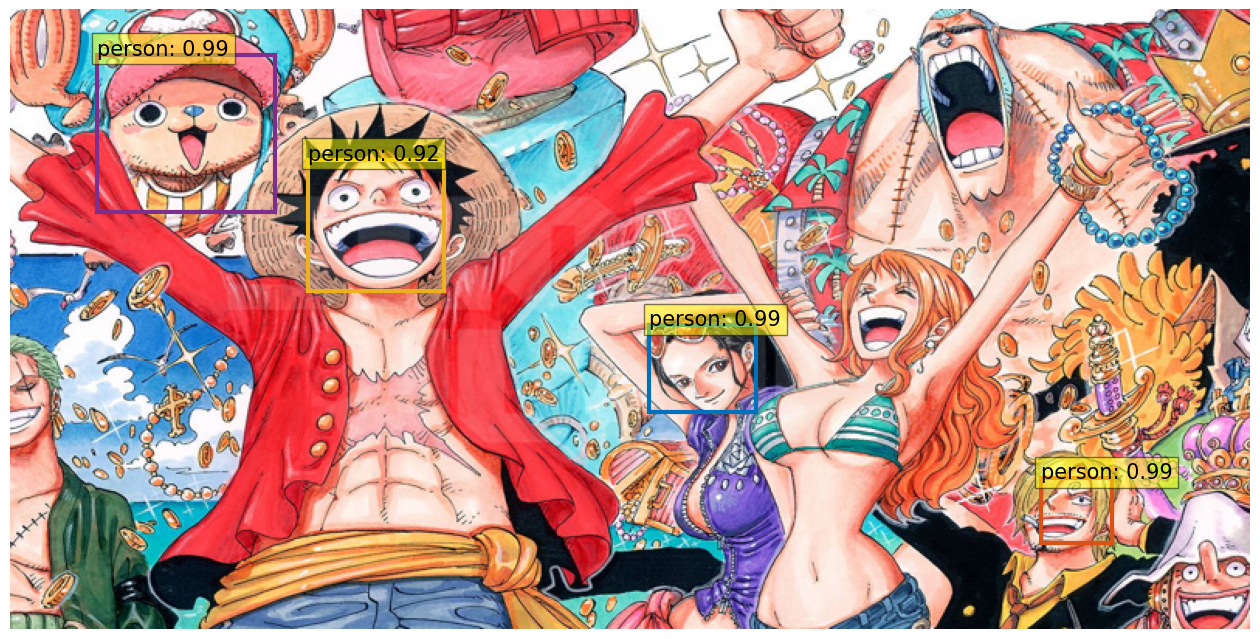

tensor([[412.0249, 203.5511, 480.9680, 259.7410],
        [664.4534, 302.2133, 710.2003, 343.8180],
        [191.7795,  96.7159, 279.6304, 181.6367],
        [ 55.8208,  29.0495, 170.2884, 130.2536]], grad_fn=<MulBackward0>)


In [7]:
the_image = PIL.Image.open('/Users/jiaruili/Emotion Recognition/Code/testImg/t3.jpg').convert('RGB').resize((800,400))
scores, boxes = detect(the_image, model, transform)
plot_classes = ['person']
plot_results(the_image, scores, boxes.tolist(), plot_classes)
print(boxes)